In [ ]:
# Imports
from jax import jit, random, grad
import jax.numpy as jnp
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import optax

In [ ]:
# Function that plots input matrix, returns nothing
# Zero determinant counter denotes the number of matrices that were ignored due to high loss
def matrix_plotter(B_sum, zero_determinant_counter):
  plt.imshow(B_sum, cmap='viridis', vmin=-1, vmax=2)
  plt.colorbar()
  plt.title(f"Based on {N - zero_determinant_counter} Matrices")
  plt.xticks([])
  plt.yticks([])
  plt.show()

In [ ]:
# Function that creates the structure constant matrices from list of commutation relations
# For example of the structure of the commutation relations see spherical burgers
def comms_to_matrix(comm_list, N_gen, reverse=True):
  c = jnp.zeros((N_gen, N_gen, N_gen))
  for val in comm_list:
    c = c.at[val[1]-1,val[0]-1,val[2]-1].set(val[3])
    if reverse:       # saves work from inputting all the structure constants from reversing commutation order
      c = c.at[val[0]-1,val[1]-1,val[2]-1].set(-val[3])
  return c

# Finding B Matrix Spherical Burgers Equation <br>
Same generator order as Hydon Paper

In [ ]:
# 11 generators, order
N_gen = 3

# Construct structure constant matrices, also taking the (duplicate) structure constants into account
c_spher = jnp.zeros((N_gen,N_gen,N_gen))

# Commutator values from commutation table [row, column, result, structure constant value]
# Can also be read as [gen_1, gen_2, result_gen, structure constant value]
commutation_relations = [[1,2,2,1],[1,2,3,-2],[1,3,3,1]]

c_spher = comms_to_matrix(commutation_relations, N_gen)
print(c_spher)

[[[ 0.  0.  0.]
  [ 0. -1.  2.]
  [ 0.  0. -1.]]

 [[ 0.  1. -2.]
  [ 0.  0.  0.]
  [ 0.  0.  0.]]

 [[ 0.  0.  1.]
  [ 0.  0.  0.]
  [ 0.  0.  0.]]]


Matrix finder func using cutoff Adam and Norm loss

In [ ]:
# One large functions which can be reused easily for multiple iterations
def matrix_finder(c, N, l_rate, iters, const_pos, const_vals):
  # Shut down iterations when loss is below cutoff value
  cutoff = 0.01

  # Create list to store final B matrices in
  B_list = np.zeros((N, N_gen, N_gen))
  zero_determinant_counter = 0

  # Keep already known values of B constant
  @jit
  def keep_constant(B, indices, values):
    B = B.at[indices].set(values)
    return B

  # Calculates nonlinear condition off B for each (n,i,j) combination
  def condition_on_B(B):
    lhs = jnp.einsum("mln,il,jm->nij",c,B,B)
    rhs = jnp.einsum("jik,kn->nij",c,B)
    return lhs - rhs

  # Function that gives high loss at zero determinant
  def zero_determinant(B, sig):
    det = jnp.linalg.det(B)
    res = jnp.exp(-0.5*((det/sig)**2)) / sig
    return res

  # Loss function to be optimized, using frobenius norm
  @jit
  def loss(B):
    return jnp.sqrt(jnp.sum(condition_on_B(B)**2)) + 1*zero_determinant(B, 1e-1)

  # Use the jitted grad function from jax to calculate gradient efficiently
  grad_loss = jit(grad(loss))

  for idx in range(N):
    # Use key to generate random values for initial guess
    # Note that rerunning matrix_finder will give the same result due to getting key inside the loop
    key = random.key(idx)
    B_init = 10*random.normal(key, (N_gen,N_gen))

    # Set starting B matrix
    B = B_init
    B = keep_constant(B, const_pos, const_vals)
    print(B)

    loss_values = []

    # Initialize ADAM Solver
    solver = optax.adam(l_rate)
    params = B_init
    opt_state = solver.init(params)

    for iter in range(iters):
      # Calculate gradient of loss function for current B and find changes
      grad_adam = grad_loss(params)
      updates, opt_state = solver.update(grad_adam, opt_state, params)

      # Make changes to B (except for values at const_pos)
      params = optax.apply_updates(params, updates)
      params = keep_constant(params, const_pos, const_vals)

      # Calculate loss for new B
      param_loss = loss(params)
      loss_values.append(loss(params))

      # Stop the iterations if current loss is below cutoff value
      if param_loss < cutoff:
        break

    clear_output(wait=True)

    # calculate parameters for plotting and returning output
    B = params
    current_loss = loss(B)

    # Plotting the loss
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(loss_values, label='Loss')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f'Iteration {idx+1}, Loss {current_loss:.4f}')

    # Showing the matrix B
    plt.subplot(1, 2, 2)
    plt.imshow(B, cmap='viridis', vmin=-1, vmax=1)
    plt.colorbar()
    plt.title('Matrix B')
    plt.xticks([])
    plt.yticks([])

    display(plt.gcf())
    plt.close()

    # If the loss value of final iteration is below twice the cutoff value, include it
    if current_loss < cutoff*2:
      B_list[idx] = B
    else:
      zero_determinant_counter +=1   # Counts number of simulations not included in B_sum

  # Average of all converged B matrices
  B_sum = jnp.sum(jnp.abs(B_list), axis=0) / (N - zero_determinant_counter)

  return B_sum, zero_determinant_counter

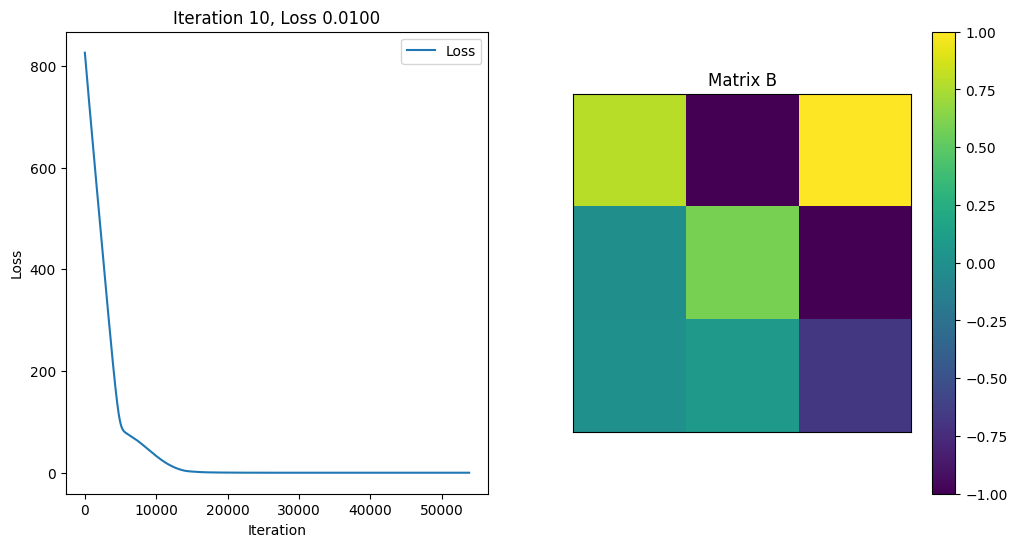

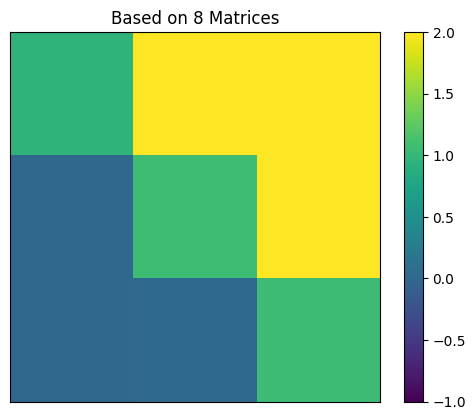

In [ ]:
# Number of sims
N = 10
learning_rate = 1e-3
iterations = 100_000

# List of indices of which the value of B matrix is known to be zero
#zero_list = jnp.array([])

# Tuple of rows and columns of each known zero entry
zero_list = ((), ())
y = np.array([0 for _ in range(len(zero_list[0]))])

# Call the function with all the right parameters
B_sum, zero_determinant_counter = matrix_finder(c_spher, N, learning_rate, iterations, zero_list, y)

# Display output
matrix_plotter(B_sum, zero_determinant_counter)

Saving this figure

In [ ]:
plt.imshow(B_sum, cmap='viridis', vmin=-1, vmax=2)
plt.colorbar()
plt.title(f"Based on {N - zero_determinant_counter} Matrices")
plt.xticks([])
plt.yticks([])
#plt.savefig("spher-noadj-adam-cutoff0.01-n10-l1e3-i100_000.pdf",bbox_inches='tight')
plt.show()

# Finding B Matrix Heat Equation (Allow Loss < 5)

In [ ]:
N_gen = 6

# Construct structure constant matrices, also taking the (duplicate) structure constants into account
c_heat = jnp.zeros((N_gen,N_gen,N_gen))

# regular values   (same generator order as in R. J. Gray)
c_heat = c_heat.at[3,0,0].set(1)
c_heat = c_heat.at[4,3,4].set(1)
c_heat = c_heat.at[4,0,2].set(-1)

c_heat = c_heat.at[5,0,4].set(2)
c_heat = c_heat.at[3,1,1].set(2)
c_heat = c_heat.at[4,1,0].set(2)
c_heat = c_heat.at[5,3,5].set(2)

c_heat = c_heat.at[5,1,2].set(-2)
c_heat = c_heat.at[5,1,3].set(4)

# reverse values
c_heat = c_heat.at[0,3,0].set(-1)
c_heat = c_heat.at[3,4,4].set(-1)
c_heat = c_heat.at[0,4,2].set(1)

c_heat = c_heat.at[0,5,4].set(-2)
c_heat = c_heat.at[1,3,1].set(-2)
c_heat = c_heat.at[1,4,0].set(-2)
c_heat = c_heat.at[3,5,5].set(-2)

c_heat = c_heat.at[1,5,2].set(2)
c_heat = c_heat.at[1,5,3].set(-4)

In [ ]:
# One large functions which can be reused easily for multiple iterations
def matrix_finder(N, l_rate, iters, idx_positions, idx_vals, solver=None):

  # Create list to store final B matrices in
  B_list = np.zeros((N, N_gen, N_gen))
  zero_determinant_counter = 0

  # Keep already known values of B constant
  @jit
  def keep_constant(B, indices):
    B = B.at[indices].set(y)
    return B

  # condition on B
  def condition_on_B(B):
    lhs = jnp.einsum("mln,il,jm->nij",c_heat,B,B)
    rhs = jnp.einsum("jik,kn->nij",c_heat,B)
    return lhs - rhs

  # zero determinant condition
  def zero_determinant(B, sig):
    det = jnp.linalg.det(B)
    res = jnp.exp(-0.5*((det/sig)**2)) / sig
    return res

  # loss function to be optimized, using frobenius norm
  @jit
  def loss(B):
    return jnp.sqrt(jnp.sum(condition_on_B(B)**2)) + 1*zero_determinant(B, 1e-1)

  @jit
  def updater(params, opt_state):
    grad_adam = grad_loss(params)
    updates, opt_state = solver.update(grad_adam, opt_state, params)
    new_params = optax.apply_updates(params, updates)
    return new_params, opt_state

  # Use the grad function from jax
  grad_loss = jit(grad(loss))

  for idx in range(N):
    # Use key to generate random values for initial guess
    key = random.key(idx)
    B_init = random.uniform(key, shape=(N_gen,N_gen),minval=-5, maxval=5)

    # Set starting B matrix
    B = B_init
    B = keep_constant(B, zero_list)
    print(B)

    loss_values = []

    # Use ADAM Solver
    solver = optax.adam(l_rate)
    params = B_init
    opt_state = solver.init(params)

    for iter in range(iterations):
      grad_adam = grad_loss(params)

      params, opt_state = updater(params, opt_state)
      params = keep_constant(params, zero_list)

      param_loss = loss(params)
      loss_values.append(loss(params))

      #if param_loss < cutoff:
      #  break


    clear_output(wait=True)

    # Use final result as B matrix
    B = params
    last_loss = loss(B)
    print(last_loss)

    # Plotting the loss
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(loss_values, label='Loss')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f'Iteration {len(loss_values)}, Loss {last_loss:.4f}')

    # Showing the matrix B
    plt.subplot(1, 2, 2)
    plt.imshow(B, cmap='viridis', vmin=-1, vmax=2)
    plt.colorbar()
    plt.title('Matrix B')
    plt.xticks([])
    plt.yticks([])

    display(plt.gcf())
    plt.close()

    if last_loss < 5:
      B_list[idx] = B
    else:
      zero_determinant_counter +=1


  B_sum = jnp.sum(jnp.abs(B_list), axis=0) / (N - zero_determinant_counter)

  return B_sum, zero_determinant_counter

0.0063320156


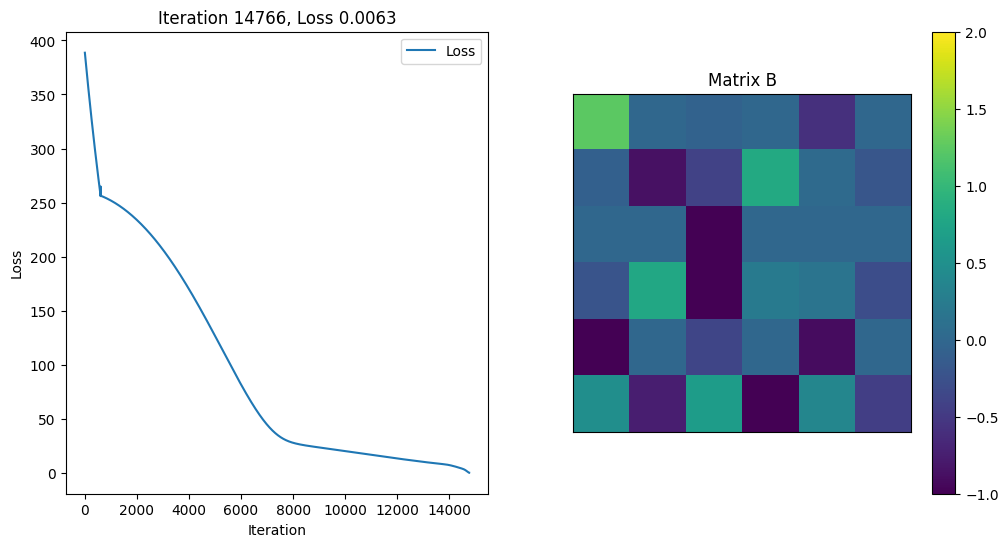

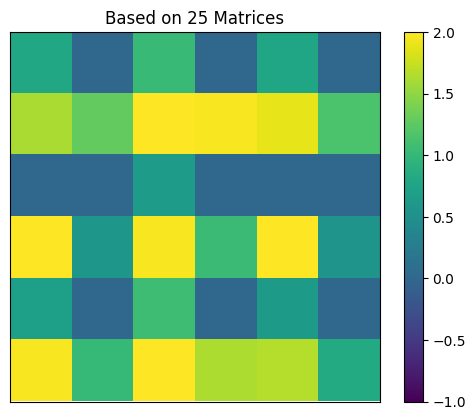

In [ ]:
# Number of sims
N = 25
learning_rate = 1e-3
iterations = 20_000

# Tuple of rows and columns of each known zero entry
zero_list = ((), ())
y = np.array([0 for _ in range(len(zero_list[0]))])

# Call the function with all the right parameters
B_sum, zero_determinant_counter = matrix_finder(N, learning_rate, iterations, zero_list, y)

# Display output
matrix_plotter(B_sum, zero_determinant_counter)

Set b[5,3]=0 using M1 and b[3,3]!=0

3.5523105


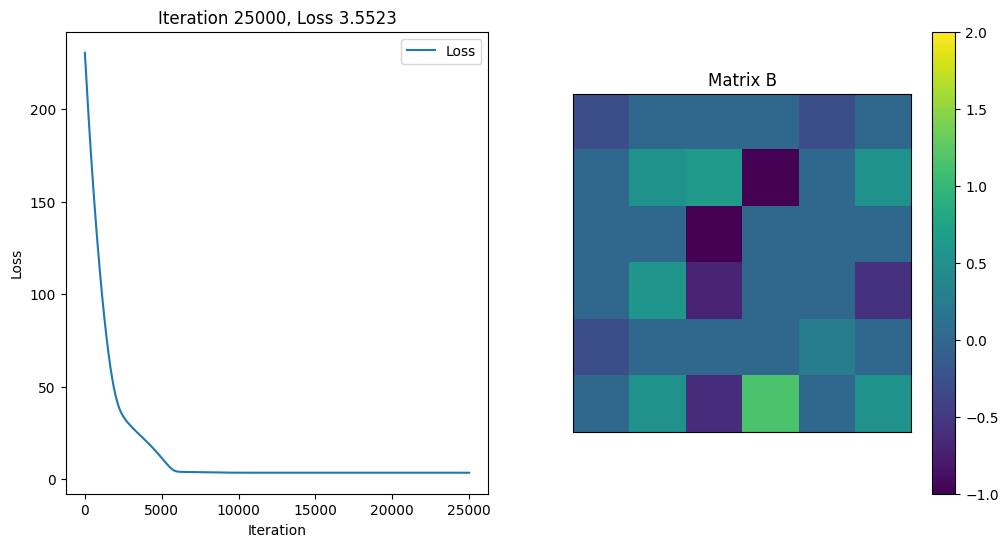

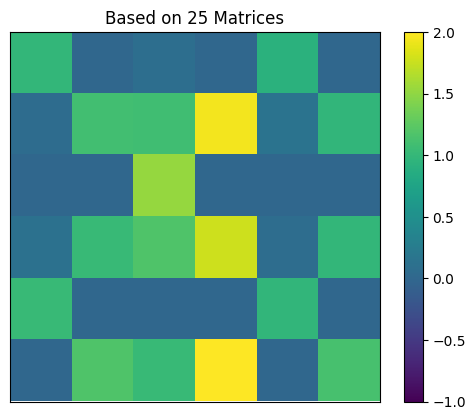

In [ ]:
# Number of sims
N = 25
learning_rate = 1e-3
iterations = 25_000

# Tuple of rows and columns of each known zero entry
zero_list = ((0,0,0,2,2,2,2,2,4,4,4,4), (1,3,5,0,1,3,4,5,1,3,5,2))
y = np.array([0 for _ in range(len(zero_list[0]))])

# Call the function with all the right parameters
B_sum, zero_determinant_counter = matrix_finder(N, learning_rate, iterations, zero_list, y)

# Display output
matrix_plotter(B_sum, zero_determinant_counter)

Sets b[6,1]=b[6,5]=0

Set b[1,3]=0 using M5 and b[3,3]!=0

3.55231


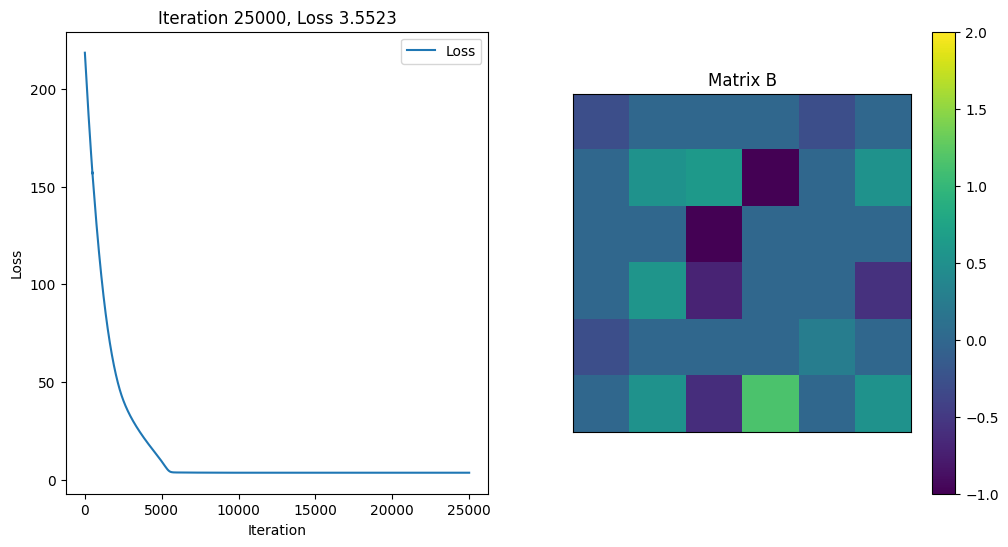

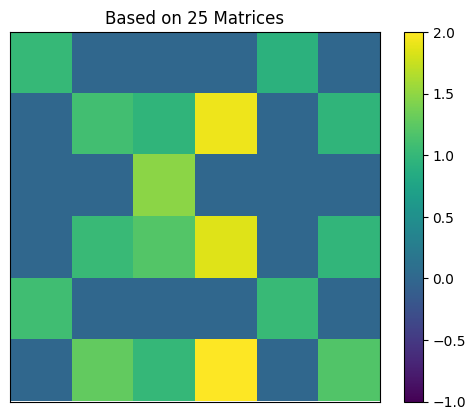

In [ ]:
# Number of sims
N = 25
learning_rate = 1e-3
iterations = 25_000

# Tuple of rows and columns of each known zero entry
zero_list = ((0,0,0,2,2,2,2,2,4,4,4,4,5,5,0), (1,3,5,0,1,3,4,5,1,3,5,2,0,4,2))
y = np.array([0 for _ in range(len(zero_list[0]))])

# Call the function with all the right parameters
B_sum, zero_determinant_counter = matrix_finder(N, learning_rate, iterations, zero_list, y)

# Display output
matrix_plotter(B_sum, zero_determinant_counter)

Sets b[2,1]=b[2,5]=b[4,1]=b[4,5]=0

## Assumption: b[1,1]!=0 (sets b[5,1]=0 using M2 and b[1,1!=0])





1.5794932


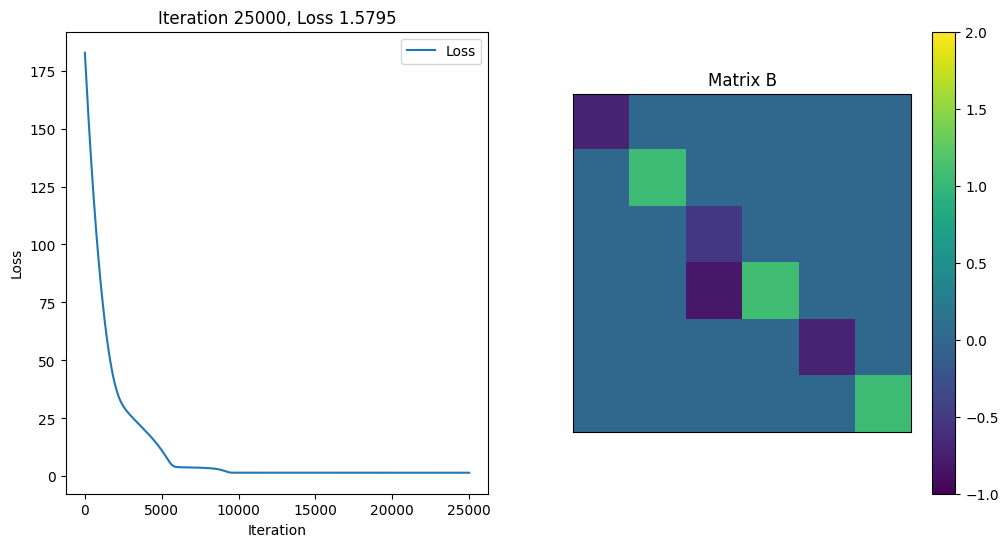

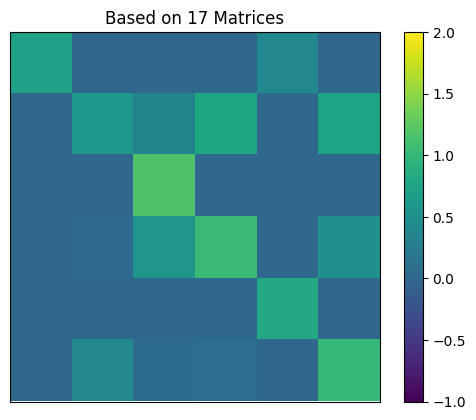

In [ ]:
# Number of sims
N = 25
learning_rate = 1e-3
iterations = 25_000

# Tuple of rows and columns of each known zero entry
zero_list = ((0,0,0,2,2,2,2,2,4,4,4,4,5,5,0,1,1,3,3,4), (1,3,5,0,1,3,4,5,1,3,5,2,0,4,2,0,4,0,4,0))
y = np.array([0 for _ in range(len(zero_list[0]))])

# Call the function with all the right parameters
B_sum, zero_determinant_counter = matrix_finder(N, learning_rate, iterations, zero_list, y)

# Display output
matrix_plotter(B_sum, zero_determinant_counter)

Conservatively, no new info (could see b[4,2], b[6,3] and b[6,4] as 0)

Set b[1,5]=0 using M6 and b[5,5]!=0

1.579493


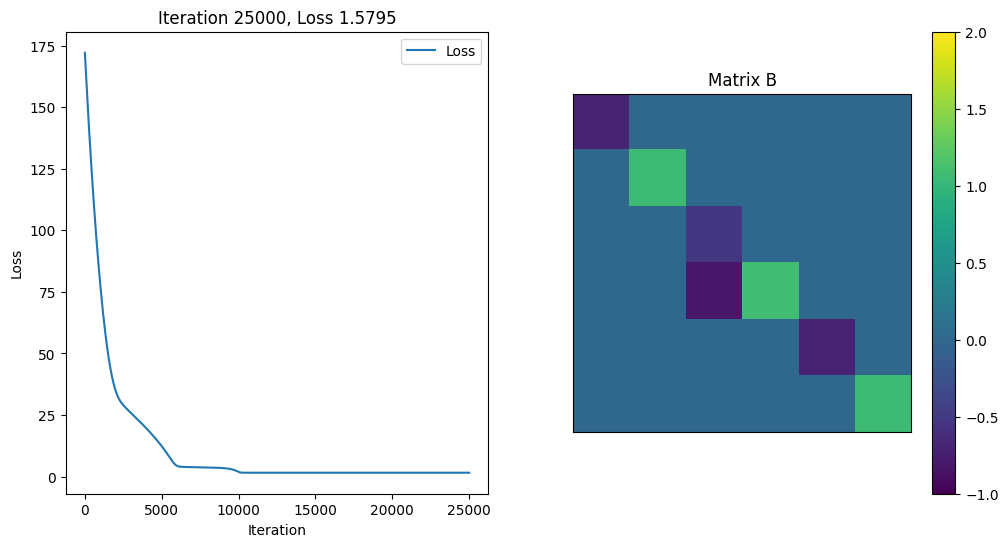

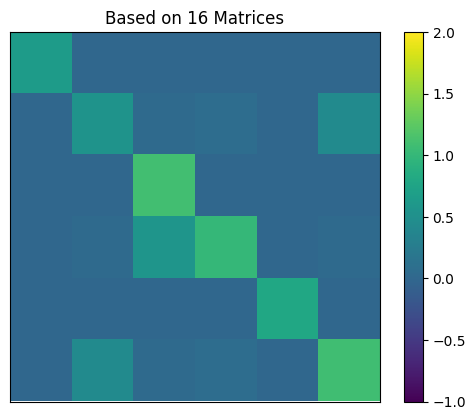

In [ ]:
# Number of sims
N = 25
learning_rate = 1e-3
iterations = 25_000

# Tuple of rows and columns of each known zero entry
zero_list = ((0,0,0,2,2,2,2,2,4,4,4,4,5,5,0,1,1,3,3,4,0), (1,3,5,0,1,3,4,5,1,3,5,2,0,4,2,0,4,0,4,0,4))
y = np.array([0 for _ in range(len(zero_list[0]))])

# Call the function with all the right parameters
B_sum, zero_determinant_counter = matrix_finder(N, learning_rate, iterations, zero_list, y)

# Display output
matrix_plotter(B_sum, zero_determinant_counter)

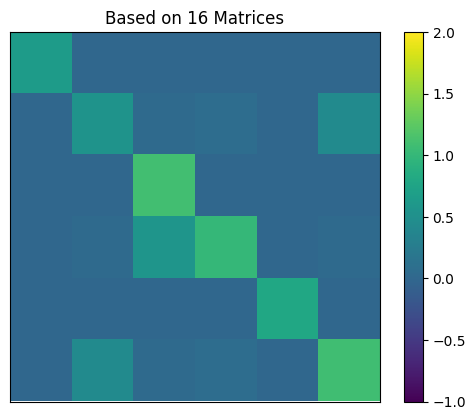

In [ ]:
plt.imshow(B_sum, cmap='viridis', vmin=-1, vmax=2)
plt.colorbar()
plt.title(f"Based on {N - zero_determinant_counter} Matrices")
plt.xticks([])
plt.yticks([])
#plt.savefig("heat3-adj1526-adam-cutoff5-n25-l1e3-i25_000.pdf",bbox_inches='tight')
plt.savefig("heat3-adj1526-adam-cutoff5-n25-l1e3-i25_000.jpg",bbox_inches='tight')
plt.show()

## Assumption: b[1,1]=0 (do not use m2)

3.554098


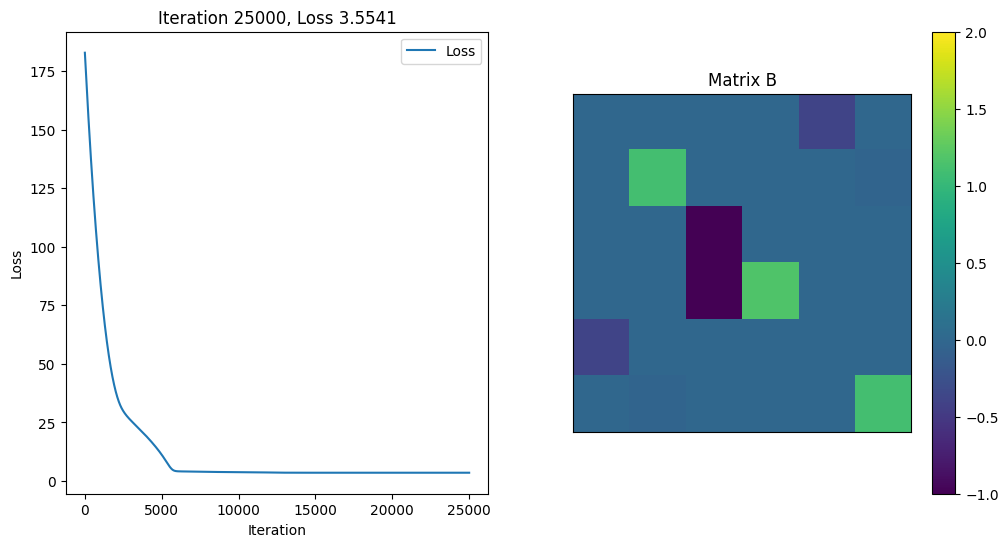

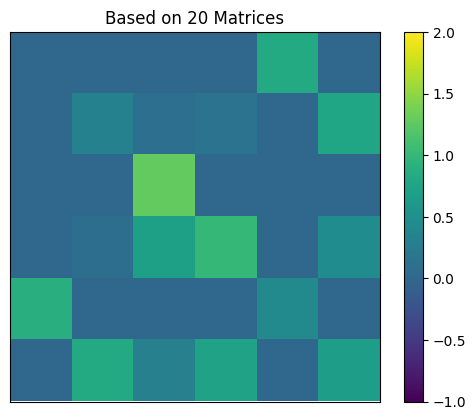

In [ ]:
# Number of sims
N = 25
learning_rate = 1e-3
iterations = 25_000

# Tuple of rows and columns of each known zero entry
zero_list = ((0,0,0,2,2,2,2,2,4,4,4,4,5,5,0,1,1,3,3,0), (1,3,5,0,1,3,4,5,1,3,5,2,0,4,2,0,4,0,4,0))
y = np.array([0 for _ in range(len(zero_list[0]))])

# Call the function with all the right parameters
B_sum, zero_determinant_counter = matrix_finder(N, learning_rate, iterations, zero_list, y)

# Display output
matrix_plotter(B_sum, zero_determinant_counter)

No new info

Set b[5,5] using M2 and b[1,5]!=0

3.554098


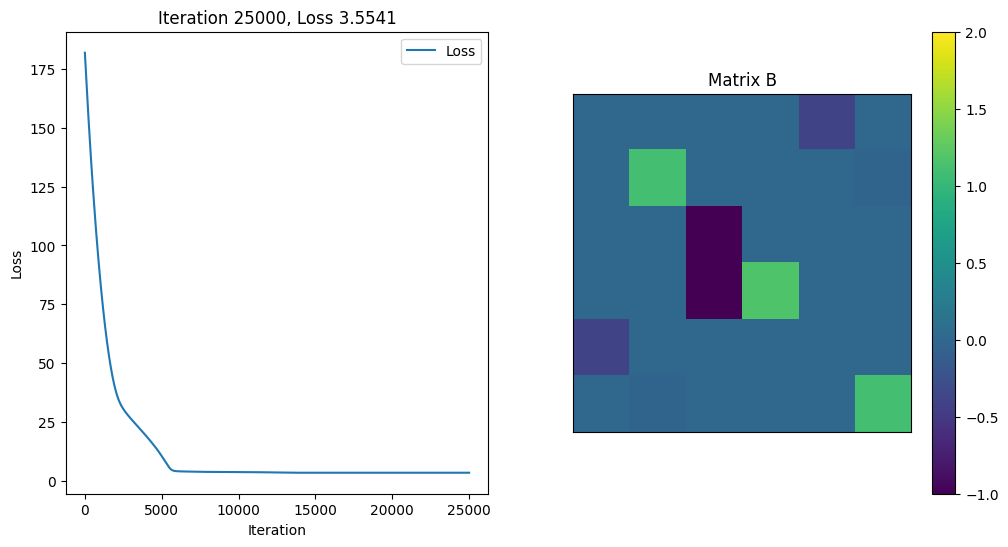

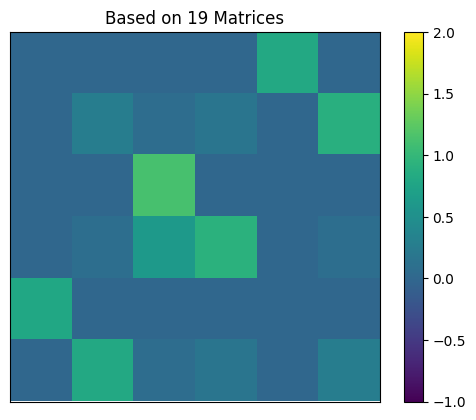

In [ ]:
# Number of sims
N = 25
learning_rate = 1e-3
iterations = 25_000

# Tuple of rows and columns of each known zero entry
zero_list = ((0,0,0,2,2,2,2,2,4,4,4,4,5,5,0,1,1,3,3,0,4), (1,3,5,0,1,3,4,5,1,3,5,2,0,4,2,0,4,0,4,0,4))
y = np.array([0 for _ in range(len(zero_list[0]))])

# Call the function with all the right parameters
B_sum, zero_determinant_counter = matrix_finder(N, learning_rate, iterations, zero_list, y)

# Display output
matrix_plotter(B_sum, zero_determinant_counter)

# Finding B Matrix Heat Equation (Loss < 1)

In [ ]:
N_gen = 6

# Construct structure constant matrices, also taking the (duplicate) structure constants into account
c_heat = jnp.zeros((N_gen,N_gen,N_gen))

# regular values   (same generator order as in R. J. Gray)
c_heat = c_heat.at[3,0,0].set(1)
c_heat = c_heat.at[4,3,4].set(1)
c_heat = c_heat.at[4,0,2].set(-1)

c_heat = c_heat.at[5,0,4].set(2)
c_heat = c_heat.at[3,1,1].set(2)
c_heat = c_heat.at[4,1,0].set(2)
c_heat = c_heat.at[5,3,5].set(2)

c_heat = c_heat.at[5,1,2].set(-2)
c_heat = c_heat.at[5,1,3].set(4)

# reverse values
c_heat = c_heat.at[0,3,0].set(-1)
c_heat = c_heat.at[3,4,4].set(-1)
c_heat = c_heat.at[0,4,2].set(1)

c_heat = c_heat.at[0,5,4].set(-2)
c_heat = c_heat.at[1,3,1].set(-2)
c_heat = c_heat.at[1,4,0].set(-2)
c_heat = c_heat.at[3,5,5].set(-2)

c_heat = c_heat.at[1,5,2].set(2)
c_heat = c_heat.at[1,5,3].set(-4)

In [ ]:
# One large functions which can be reused easily for multiple iterations
def matrix_finder(N, l_rate, iters, idx_positions, idx_vals, solver=None):

  # Create list to store final B matrices in
  B_list = np.zeros((N, N_gen, N_gen))
  zero_determinant_counter = 0

  # Keep already known values of B constant
  @jit
  def keep_constant(B, indices):
    B = B.at[indices].set(y)
    return B

  # condition on B
  def condition_on_B(B):
    lhs = jnp.einsum("mln,il,jm->nij",c_heat,B,B)
    rhs = jnp.einsum("jik,kn->nij",c_heat,B)
    return lhs - rhs

  # zero determinant condition
  def zero_determinant(B, sig):
    det = jnp.linalg.det(B)
    res = jnp.exp(-0.5*((det/sig)**2)) / sig
    return res

  # loss function to be optimized, using frobenius norm
  @jit
  def loss(B):
    return jnp.sqrt(jnp.sum(condition_on_B(B)**2)) + 1*zero_determinant(B, 1e-1)

  @jit
  def updater(params, opt_state):
    grad_adam = grad_loss(params)
    updates, opt_state = solver.update(grad_adam, opt_state, params)
    new_params = optax.apply_updates(params, updates)
    return new_params, opt_state

  # Use the grad function from jax
  grad_loss = jit(grad(loss))

  for idx in range(N):
    # Use key to generate random values for initial guess
    key = random.key(idx)
    B_init = random.uniform(key, shape=(N_gen,N_gen),minval=-5, maxval=5)

    # Set starting B matrix
    B = B_init
    B = keep_constant(B, zero_list)
    print(B)

    loss_values = []

    # Use ADAM Solver
    solver = optax.adam(l_rate)
    params = B_init
    opt_state = solver.init(params)

    for iter in range(iterations):
      grad_adam = grad_loss(params)

      params, opt_state = updater(params, opt_state)
      params = keep_constant(params, zero_list)

      param_loss = loss(params)
      loss_values.append(loss(params))

      #if param_loss < cutoff:
      #  break


    clear_output(wait=True)

    # Use final result as B matrix
    B = params
    last_loss = loss(B)
    print(last_loss)

    # Plotting the loss
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(loss_values, label='Loss')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f'Iteration {len(loss_values)}, Loss {last_loss:.4f}')

    # Showing the matrix B
    plt.subplot(1, 2, 2)
    plt.imshow(B, cmap='viridis', vmin=-1, vmax=2)
    plt.colorbar()
    plt.title('Matrix B')
    plt.xticks([])
    plt.yticks([])

    display(plt.gcf())
    plt.close()

    if last_loss < 1:
      B_list[idx] = B
    else:
      zero_determinant_counter +=1


  B_sum = jnp.sum(jnp.abs(B_list), axis=0) / (N - zero_determinant_counter)

  return B_sum, zero_determinant_counter

In [ ]:
# Number of sims
N = 25
learning_rate = 1e-3
iterations = 20_000

0.004138152


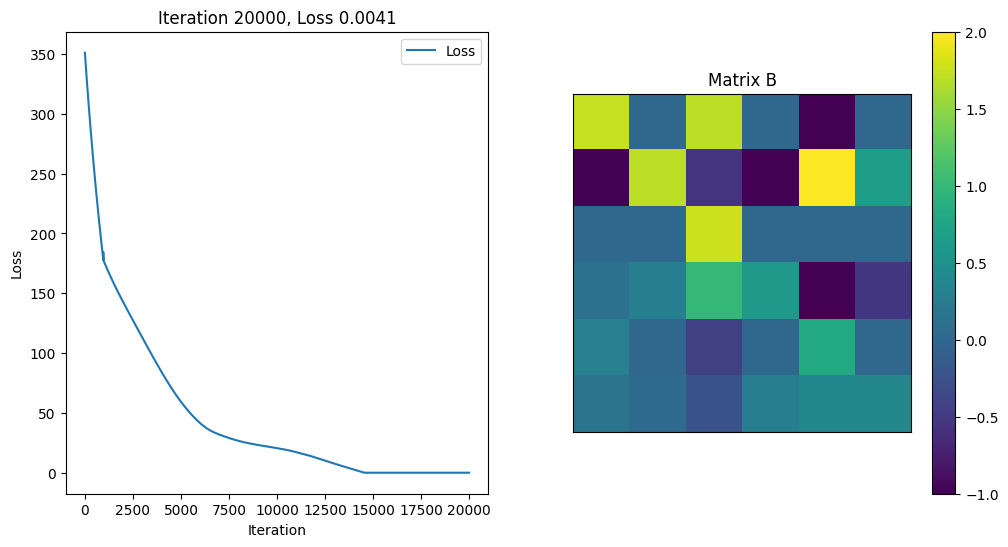

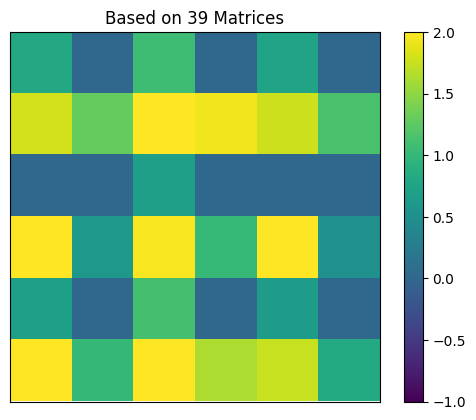

In [ ]:
# Tuple of rows and columns of each known zero entry
zero_list = ((), ())
y = np.array([0 for _ in range(len(zero_list[0]))])

# Call the function with all the right parameters
B_sum, zero_determinant_counter = matrix_finder(N, learning_rate, iterations, zero_list, y)

# Display output
matrix_plotter(B_sum, zero_determinant_counter)

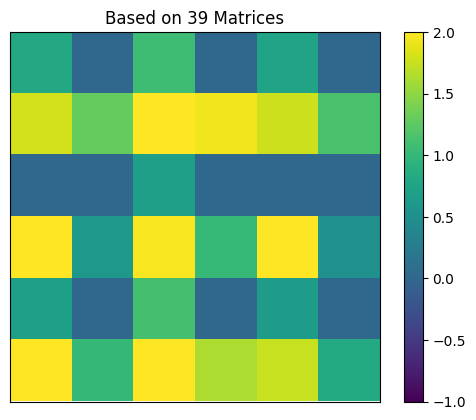

In [ ]:
plt.imshow(B_sum, cmap='viridis', vmin=-1, vmax=2)
plt.colorbar()
plt.title(f"Based on {N - zero_determinant_counter} Matrices")
plt.xticks([])
plt.yticks([])
plt.savefig("heat4-adj152(b11=0)-adam-cutoff1-n40-l1e3-i20_000.pdf",bbox_inches='tight')
plt.savefig("heat4-adj152(b11=0)-adam-cutoff1-n40-l1e3-i20_000.jpg",bbox_inches='tight')
plt.show()

Set b[1,3]=b[5,3]=0 using M5, M1

3.5523896


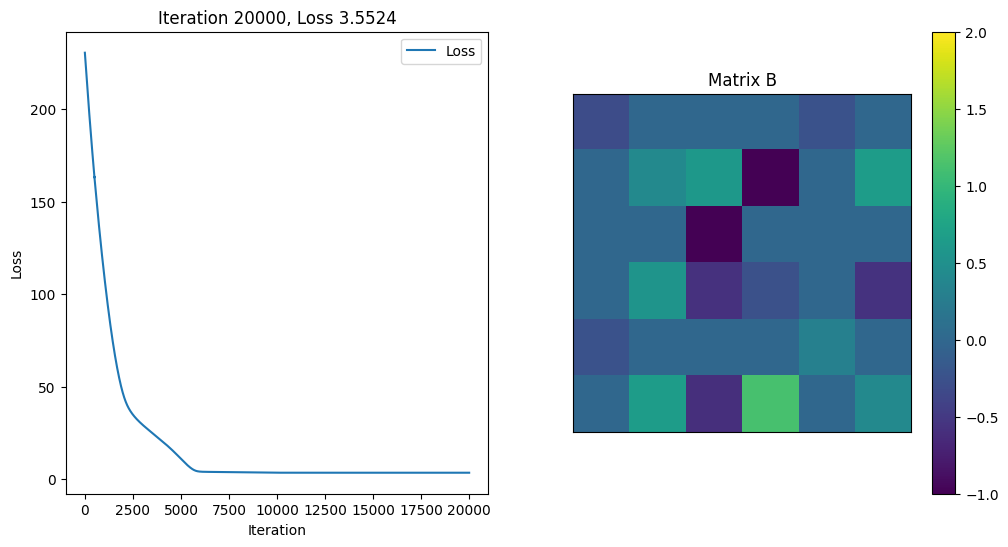

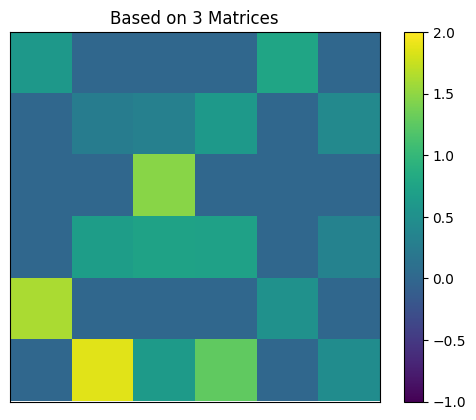

In [ ]:
# Tuple of rows and columns of each known zero entry
zero_list = ((0,0,0,2,2,2,2,2,4,4,4,0,4), (1,3,5,0,1,3,4,5,1,3,5,2,2))
y = np.array([0 for _ in range(len(zero_list[0]))])

# Call the function with all the right parameters
B_sum, zero_determinant_counter = matrix_finder(N, learning_rate, iterations, zero_list, y)

# Display output
matrix_plotter(B_sum, zero_determinant_counter)

## Assumption: b[1,1]=0

3.554098


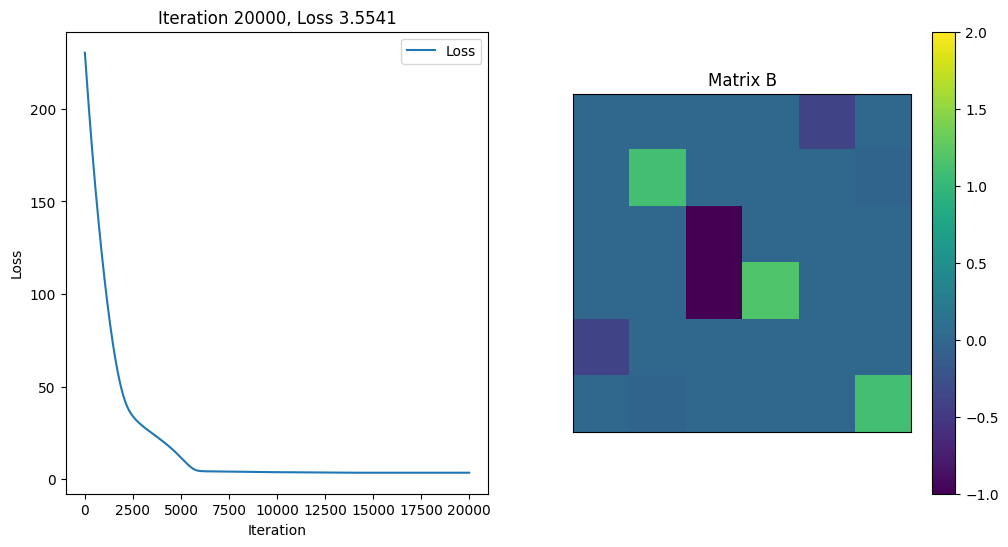

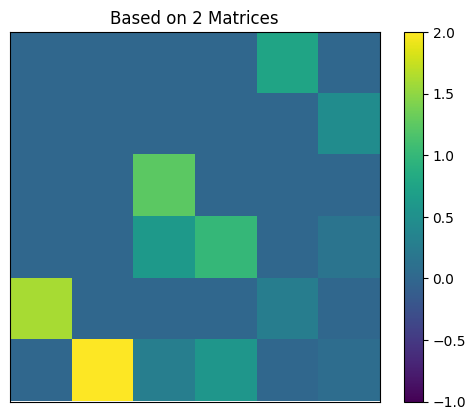

In [ ]:
# Tuple of rows and columns of each known zero entry
zero_list = ((0,0,0,2,2,2,2,2,4,4,4,0,4,0), (1,3,5,0,1,3,4,5,1,3,5,2,2,0))
y = np.array([0 for _ in range(len(zero_list[0]))])

# Call the function with all the right parameters
B_sum, zero_determinant_counter = matrix_finder(N, learning_rate, iterations, zero_list, y)

# Display output
matrix_plotter(B_sum, zero_determinant_counter)

Sets b[2,2]=b[2,3]=b[2,4]=b[4,2]=0

Set b[5,5]=0 using M2 and b[1,5]!=0

8.580457


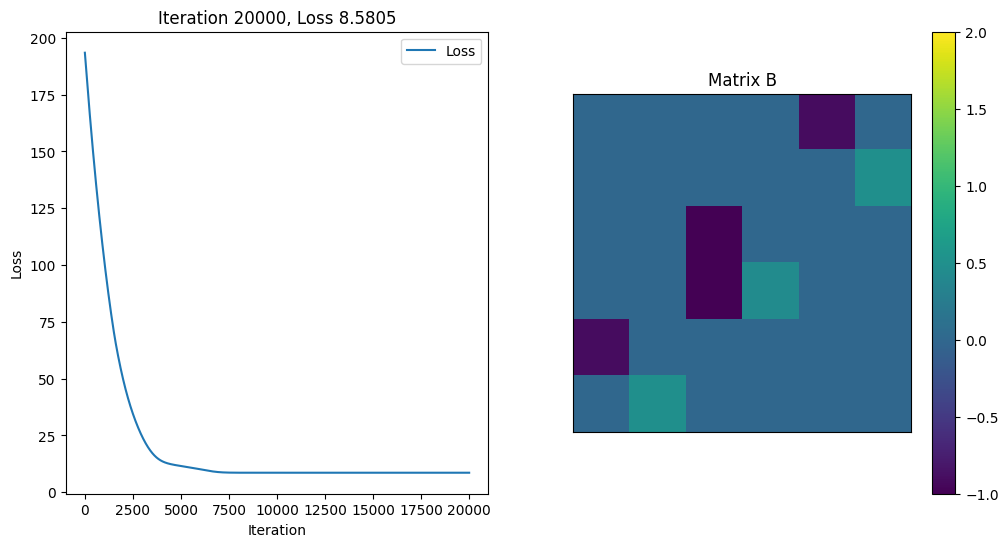

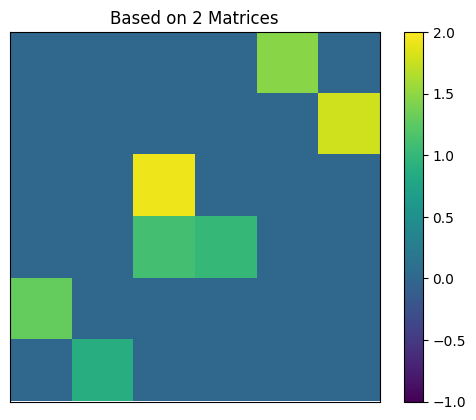

In [ ]:
# Tuple of rows and columns of each known zero entry
zero_list = ((0,0,0,2,2,2,2,2,4,4,4,0,4,0,1,1,1,3,4), (1,3,5,0,1,3,4,5,1,3,5,2,2,0,1,2,3,1,4))
y = np.array([0 for _ in range(len(zero_list[0]))])

# Call the function with all the right parameters
B_sum, zero_determinant_counter = matrix_finder(N, learning_rate, iterations, zero_list, y)

# Display output
matrix_plotter(B_sum, zero_determinant_counter)

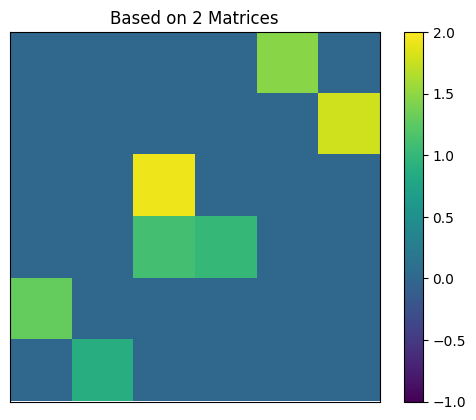

In [ ]:
plt.imshow(B_sum, cmap='viridis', vmin=-1, vmax=2)
plt.colorbar()
plt.title(f"Based on {N - zero_determinant_counter} Matrices")
plt.xticks([])
plt.yticks([])
plt.savefig("heat4-adj152(b11=0)-adam-cutoff1-n25-l1e3-i20_000.pdf",bbox_inches='tight')
plt.savefig("heat4-adj152(b11=0)-adam-cutoff1-n25-l1e3-i20_000.jpg",bbox_inches='tight')
plt.show()